## Сравнение ограничивающих рамок истинных и детектора

In [1]:
import os
import cv2
import numpy as np
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from collections import defaultdict

In [2]:
# Настройка модели
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

In [3]:
# Вычисление IoU по 2-м bb
def compute_iou(box1, box2):
    _, x1, y1, x2, y2 = box1
    _, x1_b, y1_b, x2_b, y2_b = box2

    # Вычисление пересечения
    x1_max = max(x1, x1_b)
    y1_max = max(y1, y1_b)
    x2_min = min(x2, x2_b)
    y2_min = min(y2, y2_b)

    intersection = max(0, x2_min - x1_max) * max(0, y2_min - y1_max)

    # Вычисление объединения
    area_box1 = (x2 - x1) * (y2 - y1)
    area_box2 = (x2_b - x1_b) * (y2_b - y1_b)
    union = area_box1 + area_box2 - intersection

    # Вычисление IoU
    iou = intersection / union if union != 0 else 0

    return iou

# Функция для чтения меток из txt файла
def read_labels(txt_file):
    with open(txt_file, "r") as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        # Преобразование координат из YOLO формата в формат xmin, ymin, xmax, ymax
        xmin = (x_center - width / 2) * img.shape[1]
        xmax = (x_center + width / 2) * img.shape[1]
        ymin = (y_center - height / 2) * img.shape[0]
        ymax = (y_center + height / 2) * img.shape[0]
        boxes.append([class_id, xmin, ymin, xmax, ymax])
    return boxes

# Получить ответ модели в таком же формате, что и в датасете
def get_predicts(outputs):
    # Извлечение предсказанных ограничивающих рамок и классов из outputs
    pred_boxes = outputs["instances"].pred_boxes.tensor.tolist()
    pred_classes = outputs["instances"].pred_classes.tolist()
    
    # Компонуем все вместе, как в метках нашего даатсета
    predicts = []
    for pred_class, pred_box in zip(pred_classes, pred_boxes):
        predicts.append([pred_class] + pred_box)
    
    return predicts

In [4]:
image_dir = "../test/images"
image_file = "aguanambi-1000_png_jpg.rf.7179a0df58ad6448028bc5bc21dca41e.jpg"
image_path = os.path.join(image_dir, image_file)
img = cv2.imread(image_path)
outputs = predictor(img)
predicts = get_predicts(outputs)

# Чтение истинных меток из соответствующего txt файла
txt_file = os.path.join("../test/labels", image_file.replace(".jpg", ".txt"))
true_boxes = read_labels(txt_file)

# Вычисление IoU для каждой пары истинной и предсказанной рамки

ious = []

for true_box in true_boxes:
    max_iou = 0
    for predict in predicts:
        iou = compute_iou(true_box, predict)
        if iou > max_iou:
            max_iou = iou
    ious.append(max_iou)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


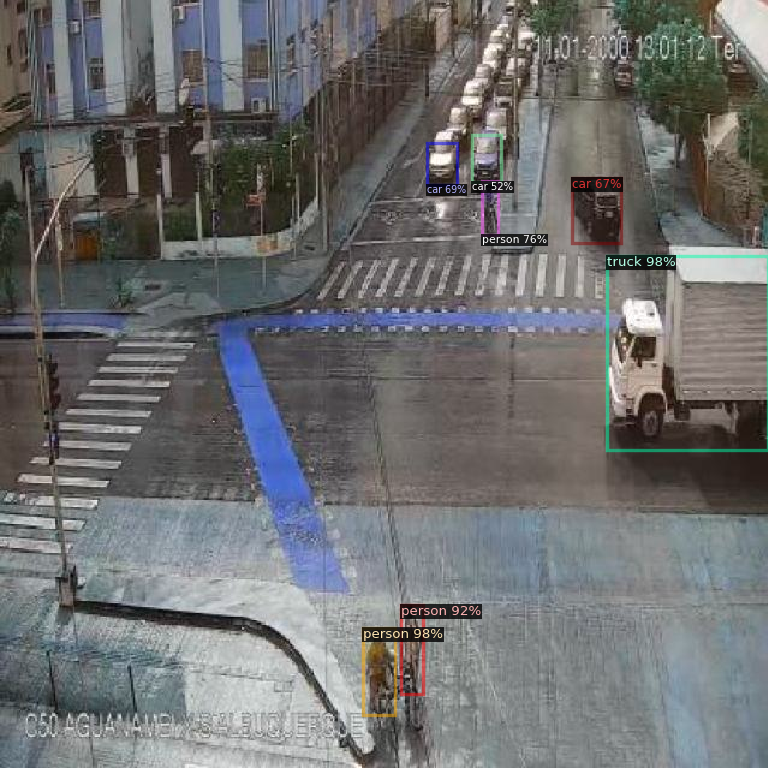

In [5]:
from PIL import Image

# Визуализация
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
out_image = out.get_image()[:, :, ::-1]

display(Image.fromarray(out_image))

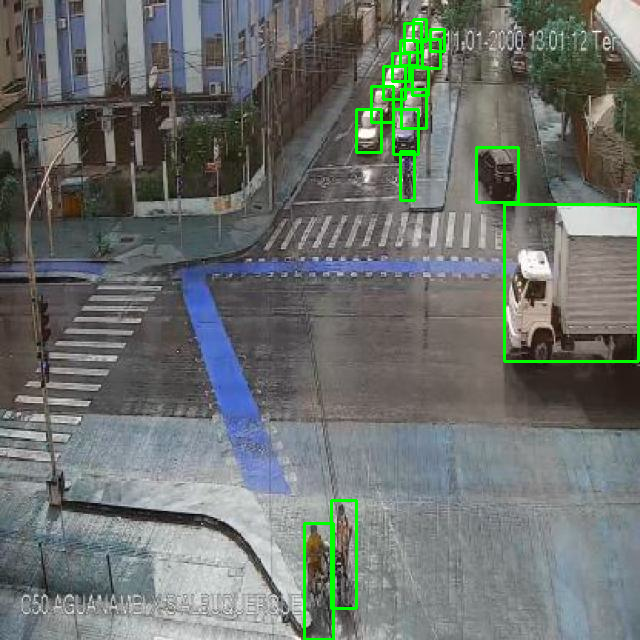

In [6]:
# Визуализация истинных ограничивающих рамок
for box in true_boxes:
    cv2.rectangle(img, (int(box[1]), int(box[2])), (int(box[3]), int(box[4])), (0, 255, 0), 2)
display(Image.fromarray(img))